In [126]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import open3d as o3d
from scipy import stats
%matplotlib inline


In [130]:
z = np.random.uniform(-10, 10, (1000,2))
current = np.random.uniform(-10, 10, (500,2))

In [129]:
likelihood = stats.norm(z)

array([[-1.41174881,  1.77682082],
       [-2.97343664,  3.17462137],
       [ 7.09280408,  6.62710457],
       ...,
       [-7.15770558,  4.11609986],
       [-3.02201745,  2.8171847 ],
       [-4.32899115, -4.86625327]])

# Check curve lidar

In [55]:
cd = pd.read_csv("../data/s_curve_variable_velocity__lidar__data.csv")
pc = pd.read_csv('../data/s_curve_variable_velocity__pc.csv')

In [58]:
pcs = np.stack([pc['pc_x'], pc['pc_y']], axis=1)

In [105]:
particle_1 = np.array([cd['positions_x_ground_truth'][100], cd['positions_y_ground_truth'][100]])
pc_diffs_1 = pcs - particle_1
pcs_in_range_1 = pcs[np.linalg.norm(pc_diffs_1, axis=1) < 10]

In [106]:
particle_2 = np.array([cd['positions_x_ground_truth'][110], cd['positions_y_ground_truth'][110]])
pc_diffs_2 = pcs - particle_2
pcs_in_range_2 = pcs[np.linalg.norm(pc_diffs_2, axis=1) < 10]

In [112]:
particle_3 = np.array([cd['positions_x_ground_truth'][250], cd['positions_y_ground_truth'][250]])
pc_diffs_3 = pcs - particle_3
pcs_in_range_3 = pcs[np.linalg.norm(pc_diffs_3, axis=1) < 10]

In [124]:
points = np.array([particle_1, particle_2, particle_3])
diffs = []
pcs_in_range = []
for p in points: 
    diff  = p-pcs
    pcs_in_range.append(pcs[np.linalg.norm(diff, axis=1)< 10])

In [125]:
pcs_in_range

[array([[ 2.06389837e+01,  1.34601885e+01],
        [ 2.15696355e+01,  1.47823699e+01],
        [ 2.21898228e+01,  1.52770514e+01],
        [ 2.29171887e+01,  1.54695552e+01],
        [ 3.18196474e+01, -1.64294857e+00],
        [ 3.15141143e+01, -1.60540130e+00],
        [ 2.29525122e+01,  1.57010911e+01],
        [ 2.31892984e+01,  1.60392416e+01],
        [ 2.34369429e+01,  1.58455436e+01],
        [ 3.40575418e+01, -3.88187536e-01],
        [ 3.45245475e+01,  2.36690968e-02],
        [ 3.52318912e+01,  5.32678041e-01],
        [ 2.68879676e+01, -2.00805263e+00],
        [ 2.80760660e+01, -1.45589733e+00],
        [ 2.81325248e+01, -1.74963057e+00],
        [ 2.82732718e+01, -1.45746953e+00],
        [ 2.87806951e+01, -1.12043621e+00],
        [ 2.89378402e+01, -1.01803828e+00],
        [ 2.91900815e+01, -1.37340294e+00],
        [ 3.02476793e+01, -4.85549619e-01],
        [ 3.02990408e+01, -5.02525290e-01],
        [ 3.11888636e+01, -8.47524656e-01],
        [ 3.12569828e+01, -5.737

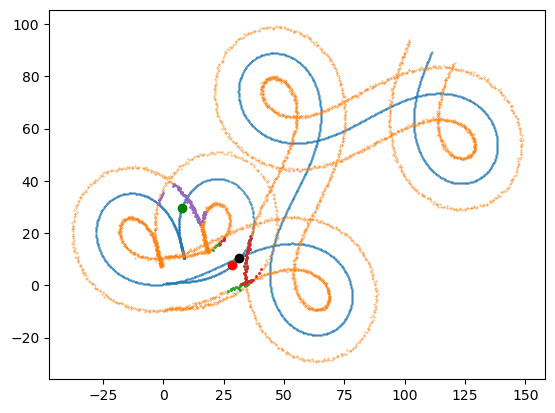

In [90]:
plt.scatter(cd['positions_x_ground_truth'], cd['positions_y_ground_truth'], s=0.15)
plt.scatter(pc['pc_x'], pc['pc_y'], s=0.1)
plt.scatter(point_1[0], point_1[1], c="red")
plt.scatter(pcs_in_range_1[:,0], pcs_in_range_1[:,1], s=1)

plt.scatter(point_2[0], point_2[1], c="black")
plt.scatter(pcs_in_range_2[:,0], pcs_in_range_2[:,1], s=1)

plt.scatter(point_3[0], point_3[1], c="green")
plt.scatter(pcs_in_range_3[:,0], pcs_in_range_3[:,1], s=1)


# Point Cloud Similarity

In [101]:
def get_point_cloud_similarity(pc_1, pc_2):
    smallest_dists = []
    for p in pc_1: 
        smallest = 100000
        for p2 in pc_2: 
            if (np.linalg.norm(p-p2) < smallest): 
                smallest = np.linalg.norm(p-p2)
        smallest_dists.append(smallest)
    return np.array(smallest_dists).mean()

In [102]:
pc_1_2 = get_point_cloud_similarity(pcs_in_range_1, pcs_in_range_2)
pc_2_3 = get_point_cloud_similarity(pcs_in_range_2, pcs_in_range_3)
pc_1_3 = get_point_cloud_similarity(pcs_in_range_1, pcs_in_range_3)

print(pc_1_2, pc_2_3, pc_1_3)

0.8224023923944244 24.277551511559125 25.46235391431421


In [98]:
len(pcs_in_range_1)

74

## LIDAR data generation

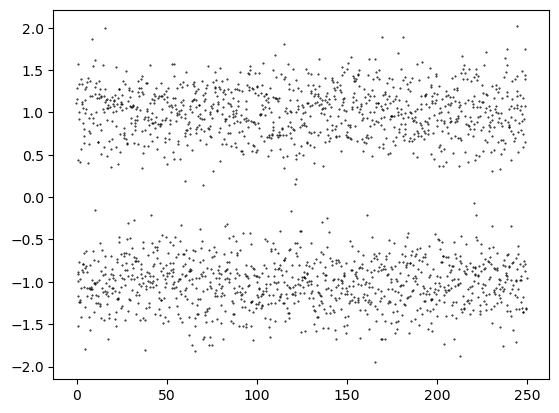

In [28]:
plt.scatter(pc['pc_x'], pc['pc_y'], s=0.2, c="black")

## Map Point Cloud Data

In [8]:
pc = pd.read_csv("../data/map/map_pc.csv")
pc['point_y'] = -pc['point_y']
pc.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/map/map_pc.csv'

In [68]:
pc.shape

(799539, 11)

In [69]:
def get_rotation_matrix(theta): 
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

def linear_coord_transformation(local_pos: np.ndarray, rot_matrix: np.ndarray, global_pos):
    global_pos = np.dot(local_pos, rot_matrix) + global_pos
    return global_pos

In [70]:
pc_trans = []
for i,p in pc.iterrows():
     rot_mat = get_rotation_matrix(p['rot_yaw'])
     pc_trans.append(linear_coord_transformation(np.array([p['point_x'], p['point_y']]), rot_mat, np.array([p['loc_x'], p['loc_y']])))
pc_trans = np.array(pc_trans)

In [71]:
%matplotlib qt
plt.scatter(pc_trans[:,0], pc_trans[:,1], s=0.001)

In [7]:
angle = np.deg2rad(45)
add = np.deg2rad(90)
vector1 = np.array([np.cos(angle), np.sin(angle)])
vector2 = np.array([np.cos(angle+add), np.sin(angle+add)])
print(np.dot(vector1, vector2))

1.1102230246251565e-16


In [ ]:
plt.quiver()

## Evaluation Results

In [8]:
result_data = pd.read_csv("../data/evaluation_results/results.csv")

<BarContainer object of 4 artists>

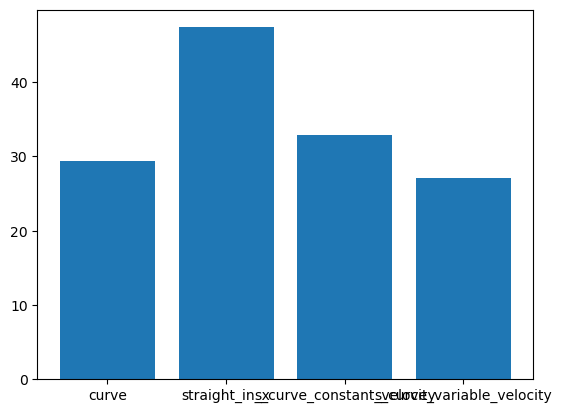

In [9]:
plt.bar(result_data['road'], result_data['mse_db'])

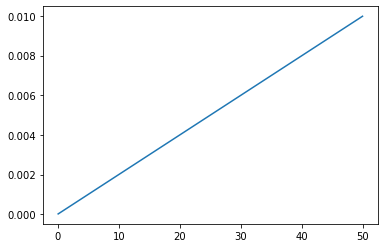

In [11]:
plt.plot(curve_data['timestamps'], curve_data['acceleration_input'])